In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, altfile='yy_quadh_bkg10_soft025_md_{base}', report=False) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile='yy_quadh_bkg10_soft025_md_{base}'), Tree(module.Run2_UL18.TTJets, altfile='yy_quadh_bkg10_soft025_md_{base}')])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [6]:
event_filter = FilterSequence(
    eightb.selected_jet_pt(),
    eightb.selected_jet_btagwp()
)

signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


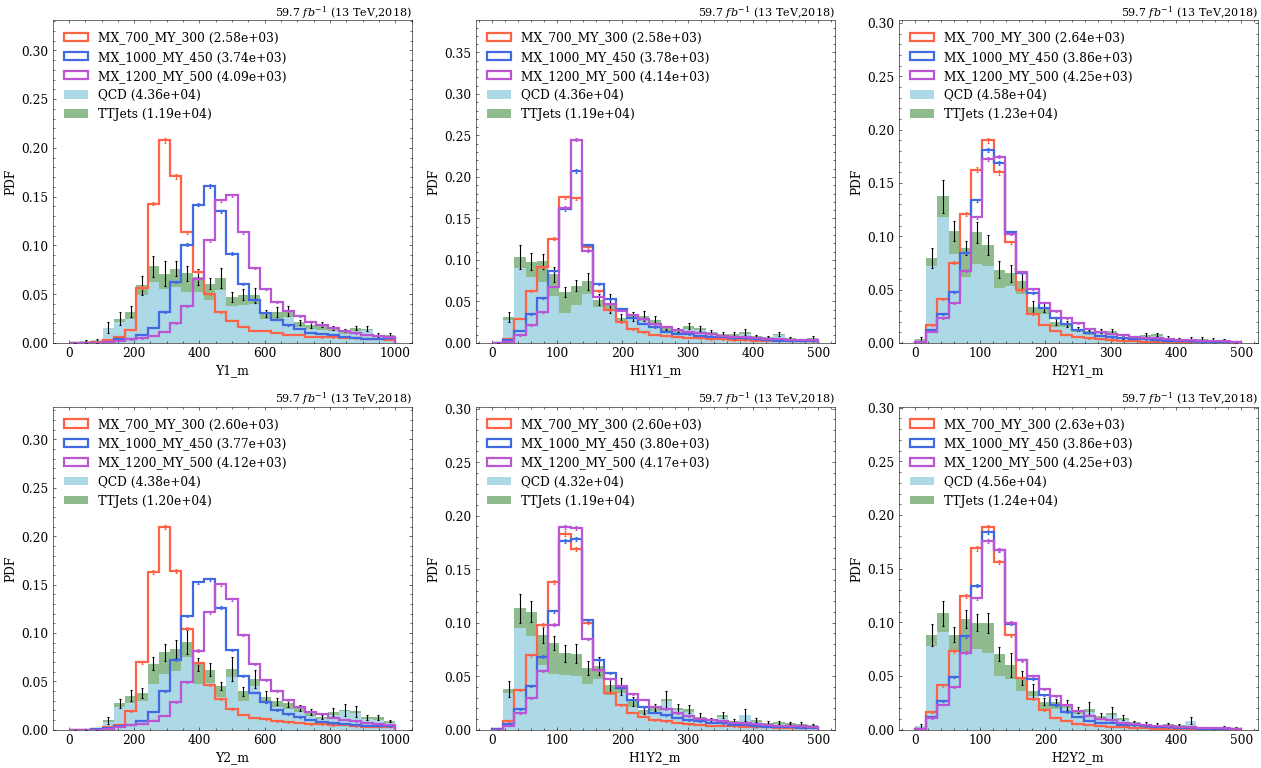

In [7]:
study.quick( 
    signal+bkg,
    legend=True,
    efficiency=True,
    varlist=['Y1_m','H1Y1_m','H2Y1_m','Y2_m','H1Y2_m','H2Y2_m'],
    binlist=[(0,1000,30),(0,500,30),(0,500,30)]*2
)

In [8]:
h4m = signal.higgs_m.apply(lambda m : m[:10000]).cat.to_numpy()

In [9]:
from scipy import optimize

def calc_dm(center):
    n = len(center)
    dm = np.sqrt( np.sum( ( (h4m[:,:n]-center)/center )**2, axis=-1 ) )
    return dm

def _find_best_(center):
    dm = calc_dm(center)
    mask = dm < 0.25
    return 1-np.mean(mask)
    # mu = ak.mean(dm[dm < 100])
    # return mu

r0 = (125,125,125,125)
center = optimize.fmin(_find_best_, r0,)
print(center)

Optimization terminated successfully.
         Current function value: 0.906467
         Iterations: 56
         Function evaluations: 142
[128.01986314 125.15121968 120.81979766 122.92191148]


In [10]:
def get_higgs_dm(t, center=center):
    dm = [
        np.abs(t.higgs_m[:,i]-m)
        for i, m in enumerate(center)
    ]  
    dm = ak_stack(dm, axis=1)
    
    rm = [
        np.abs(t.higgs_m[:,i]/m)
        for i, m in enumerate(center)
    ]  
    rm = ak_stack(rm, axis=1)
    t.extend(higgs_dm=dm, higgs_rm=rm)
(signal+bkg+data).apply(get_higgs_dm)

[None, None, None, None, None]

In [11]:
def set_hiyj_dm(t):
    dm = t.higgs_dm 
    rm = t.higgs_rm

    hiyj_dm = {
        f'H{j}Y{i}_dm':dm[ak.from_regular(t[f'Y{i}_h{j}Idx'][:,None])][:,0]
        for i in (1,2)
        for j in (1,2)
    }
    
    hiyj_rm = {
        f'H{j}Y{i}_rm':rm[ak.from_regular(t[f'Y{i}_h{j}Idx'][:,None])][:,0]
        for i in (1,2)
        for j in (1,2)
    }
    t.extend(**hiyj_dm, **hiyj_rm)

(signal+bkg+data).apply(set_hiyj_dm)

[None, None, None, None, None]

100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


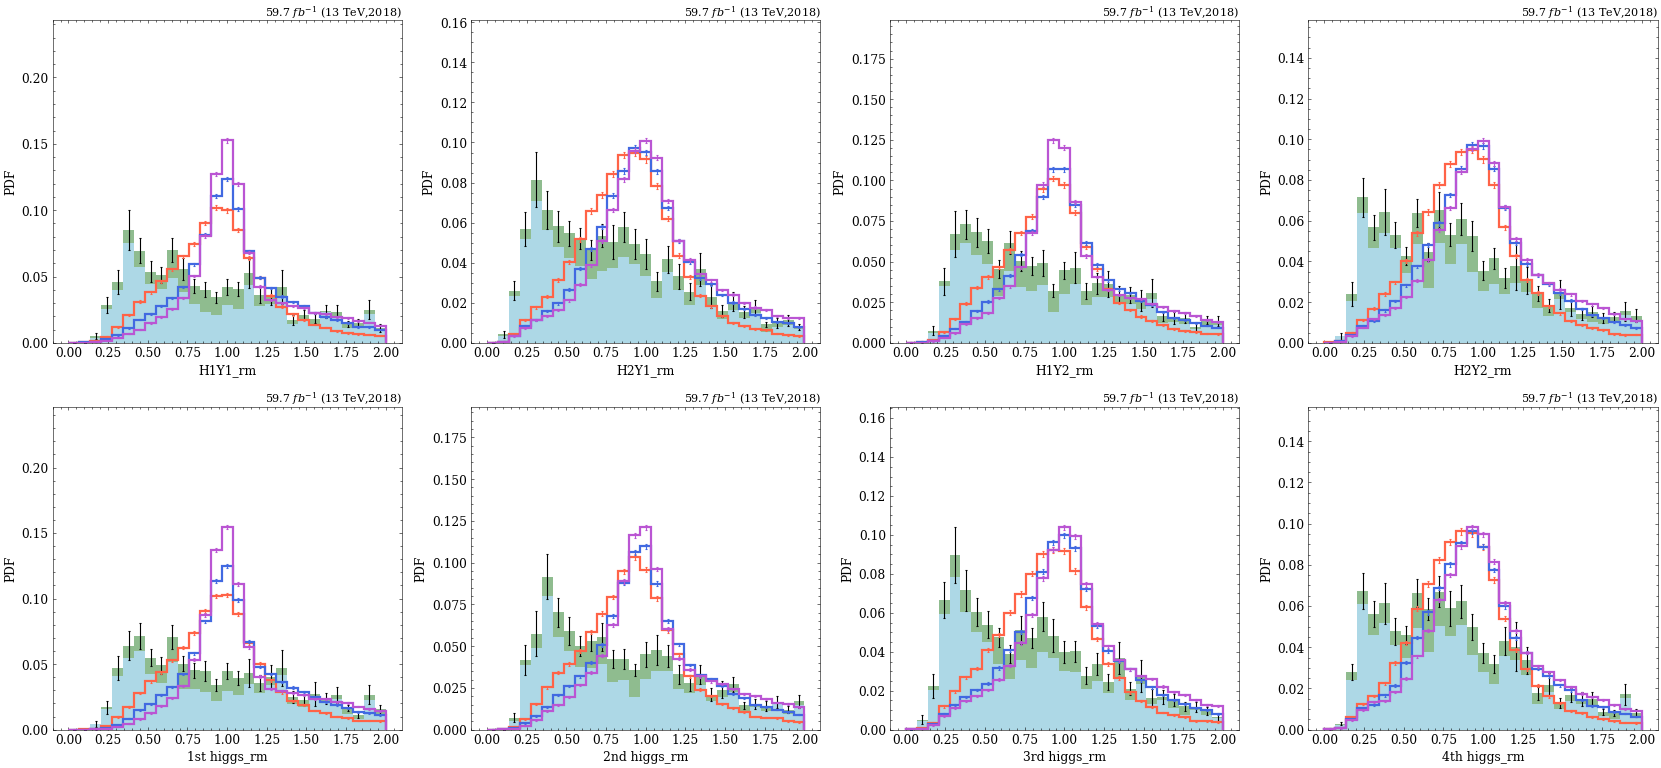

In [24]:
study.quick( 
    signal+bkg,
    efficiency=True,
    varlist=[f'{h}_rm' for h in eightb.higgslist]+[f'higgs_rm[:,{i}]' for i in range(4)],
    binlist=[(0,2,30)]*8,
    dim=(-1,4)
)

100%|██████████| 16/16 [00:21<00:00,  1.31s/it]


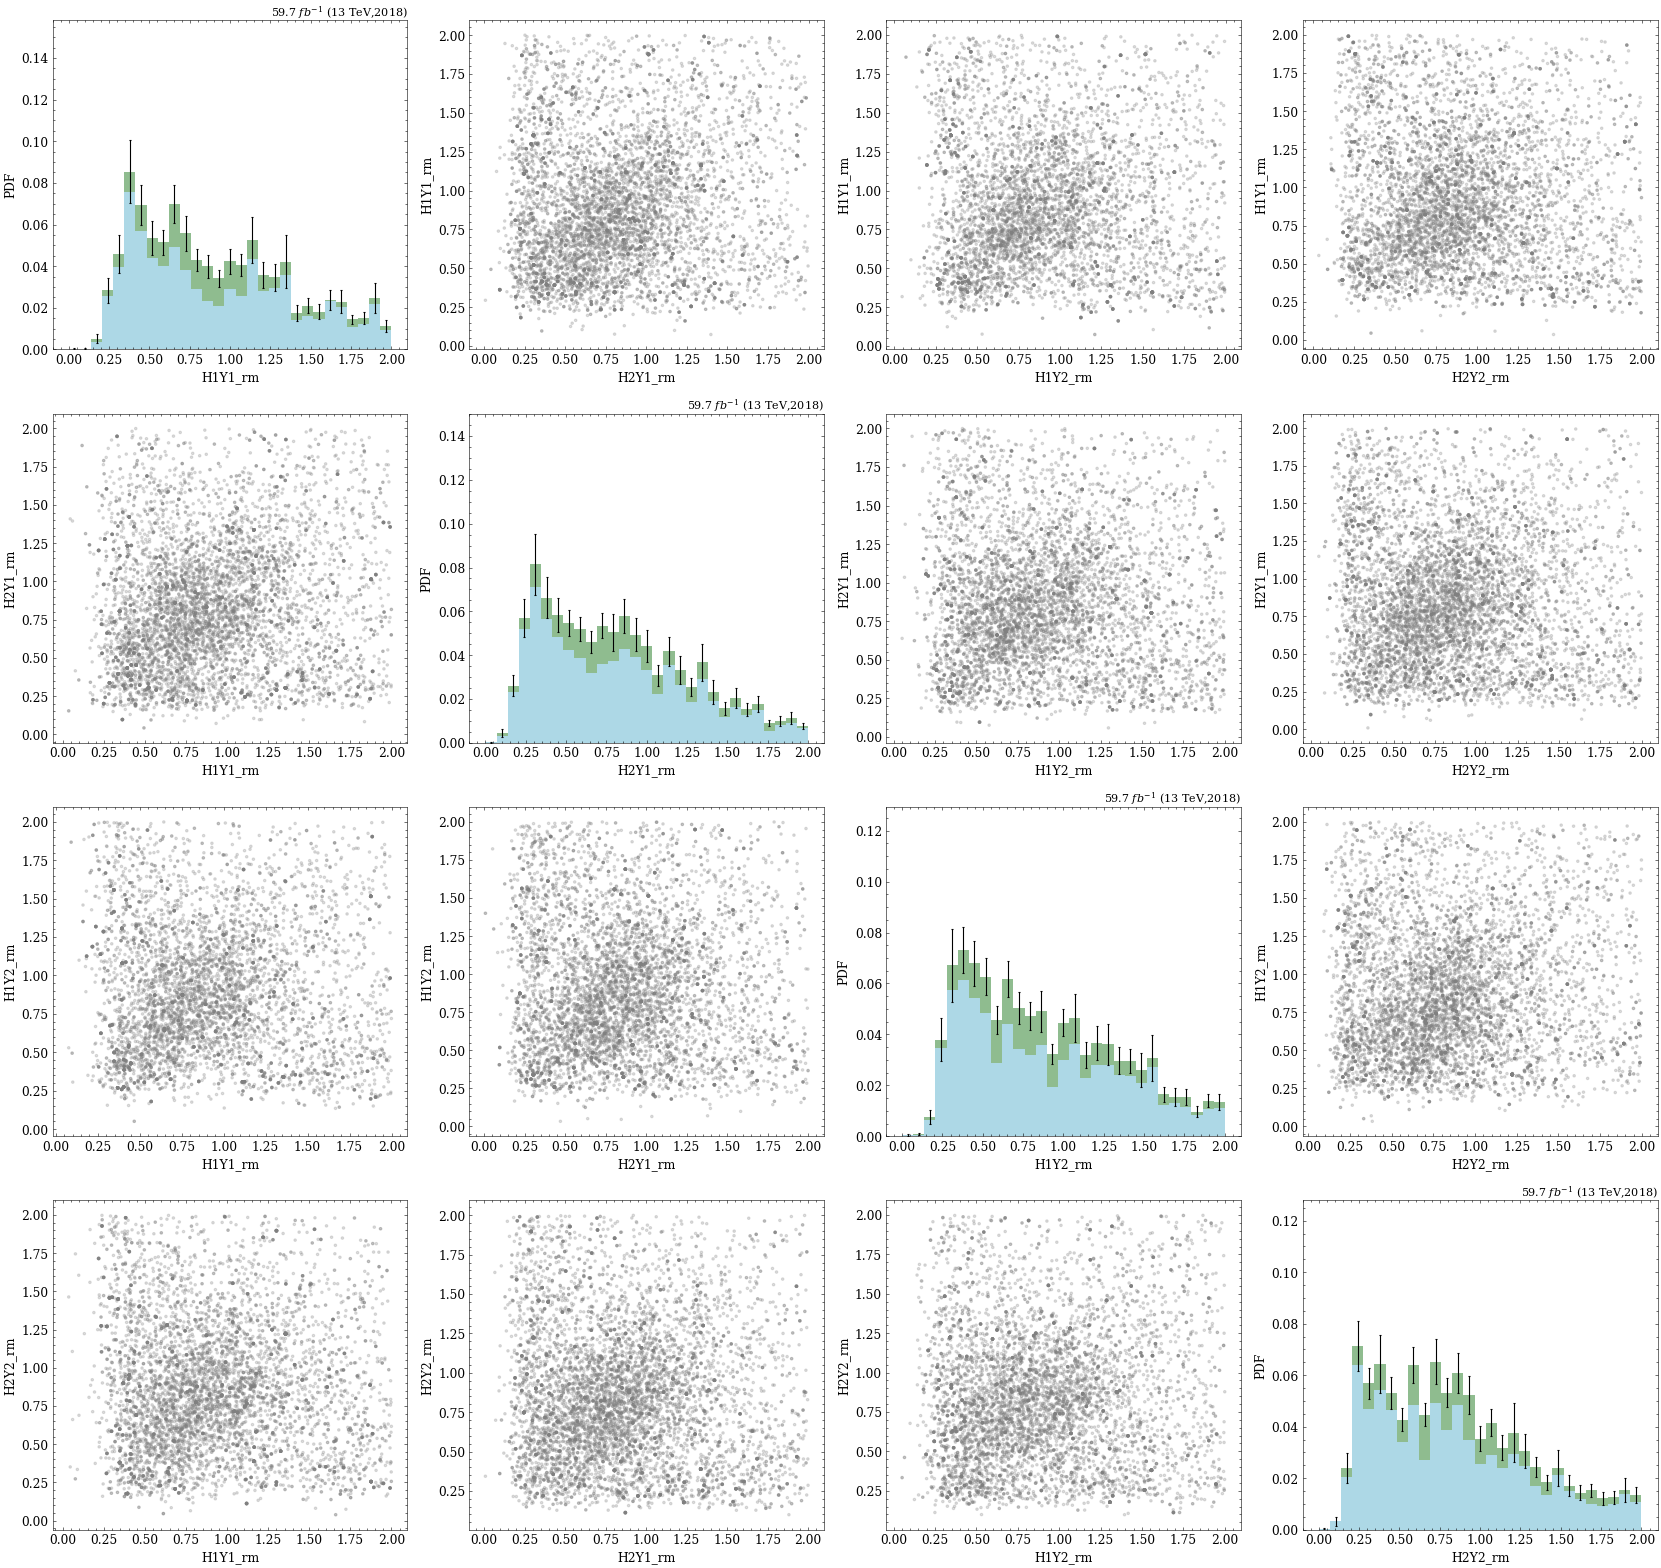

In [25]:
study.pairplot( 
    bkg,
    varlist=[f'{h}_rm' for h in eightb.higgslist],
    binlist=[(0,2,30)]*4
)

100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


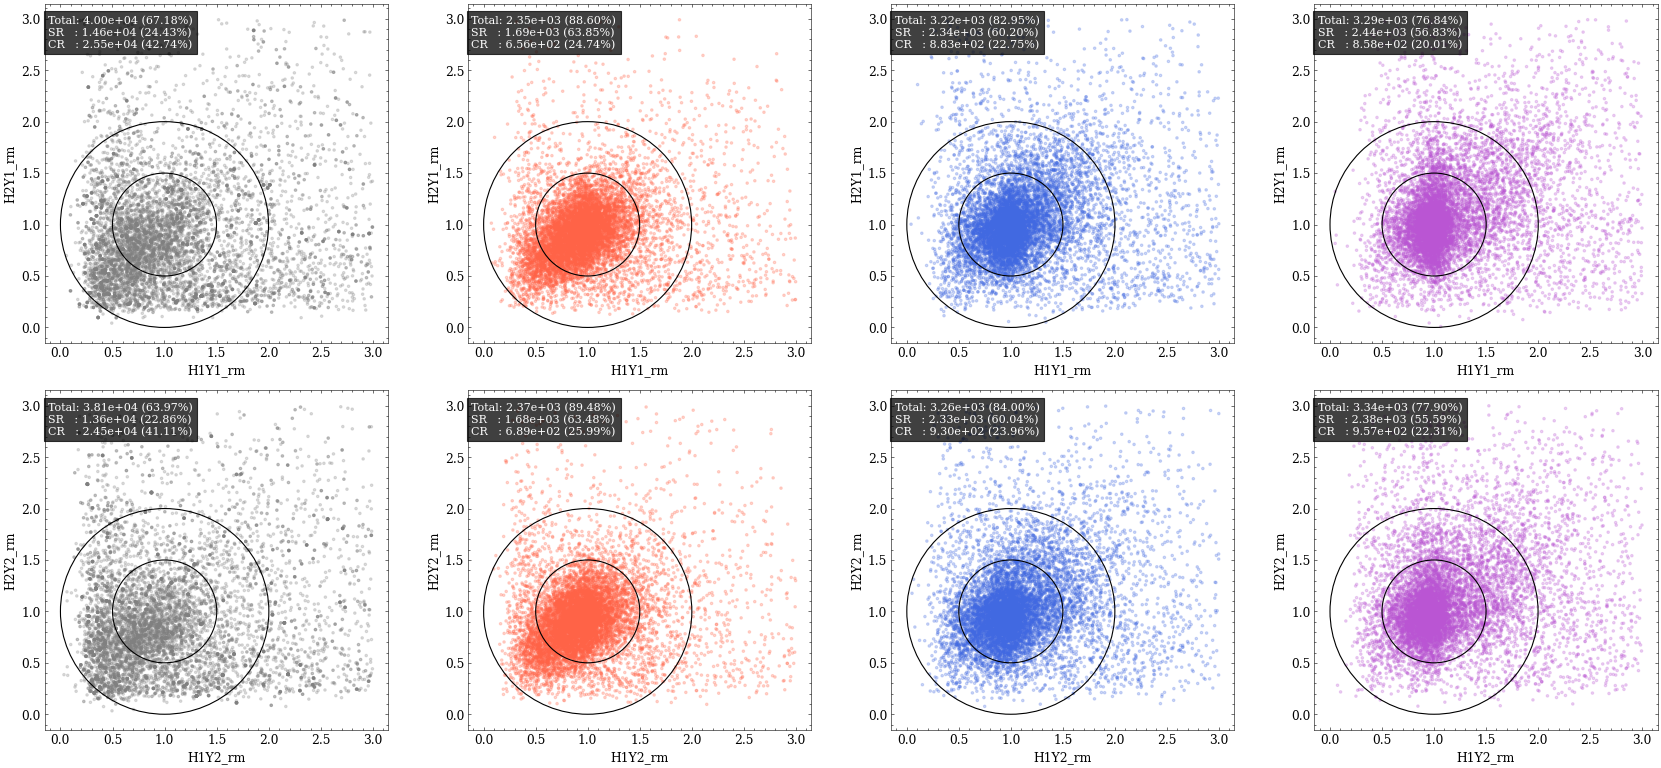

In [26]:
study.quick2d( 
    signal+bkg,
    varlist=[f'{h}_rm' for h in eightb.higgslist],
    binlist=[(0,3,30)]*4,
    scatter=True,
    exe=draw_concentric(x=1,y=1,r1=0.5,r2=1.0)
)

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


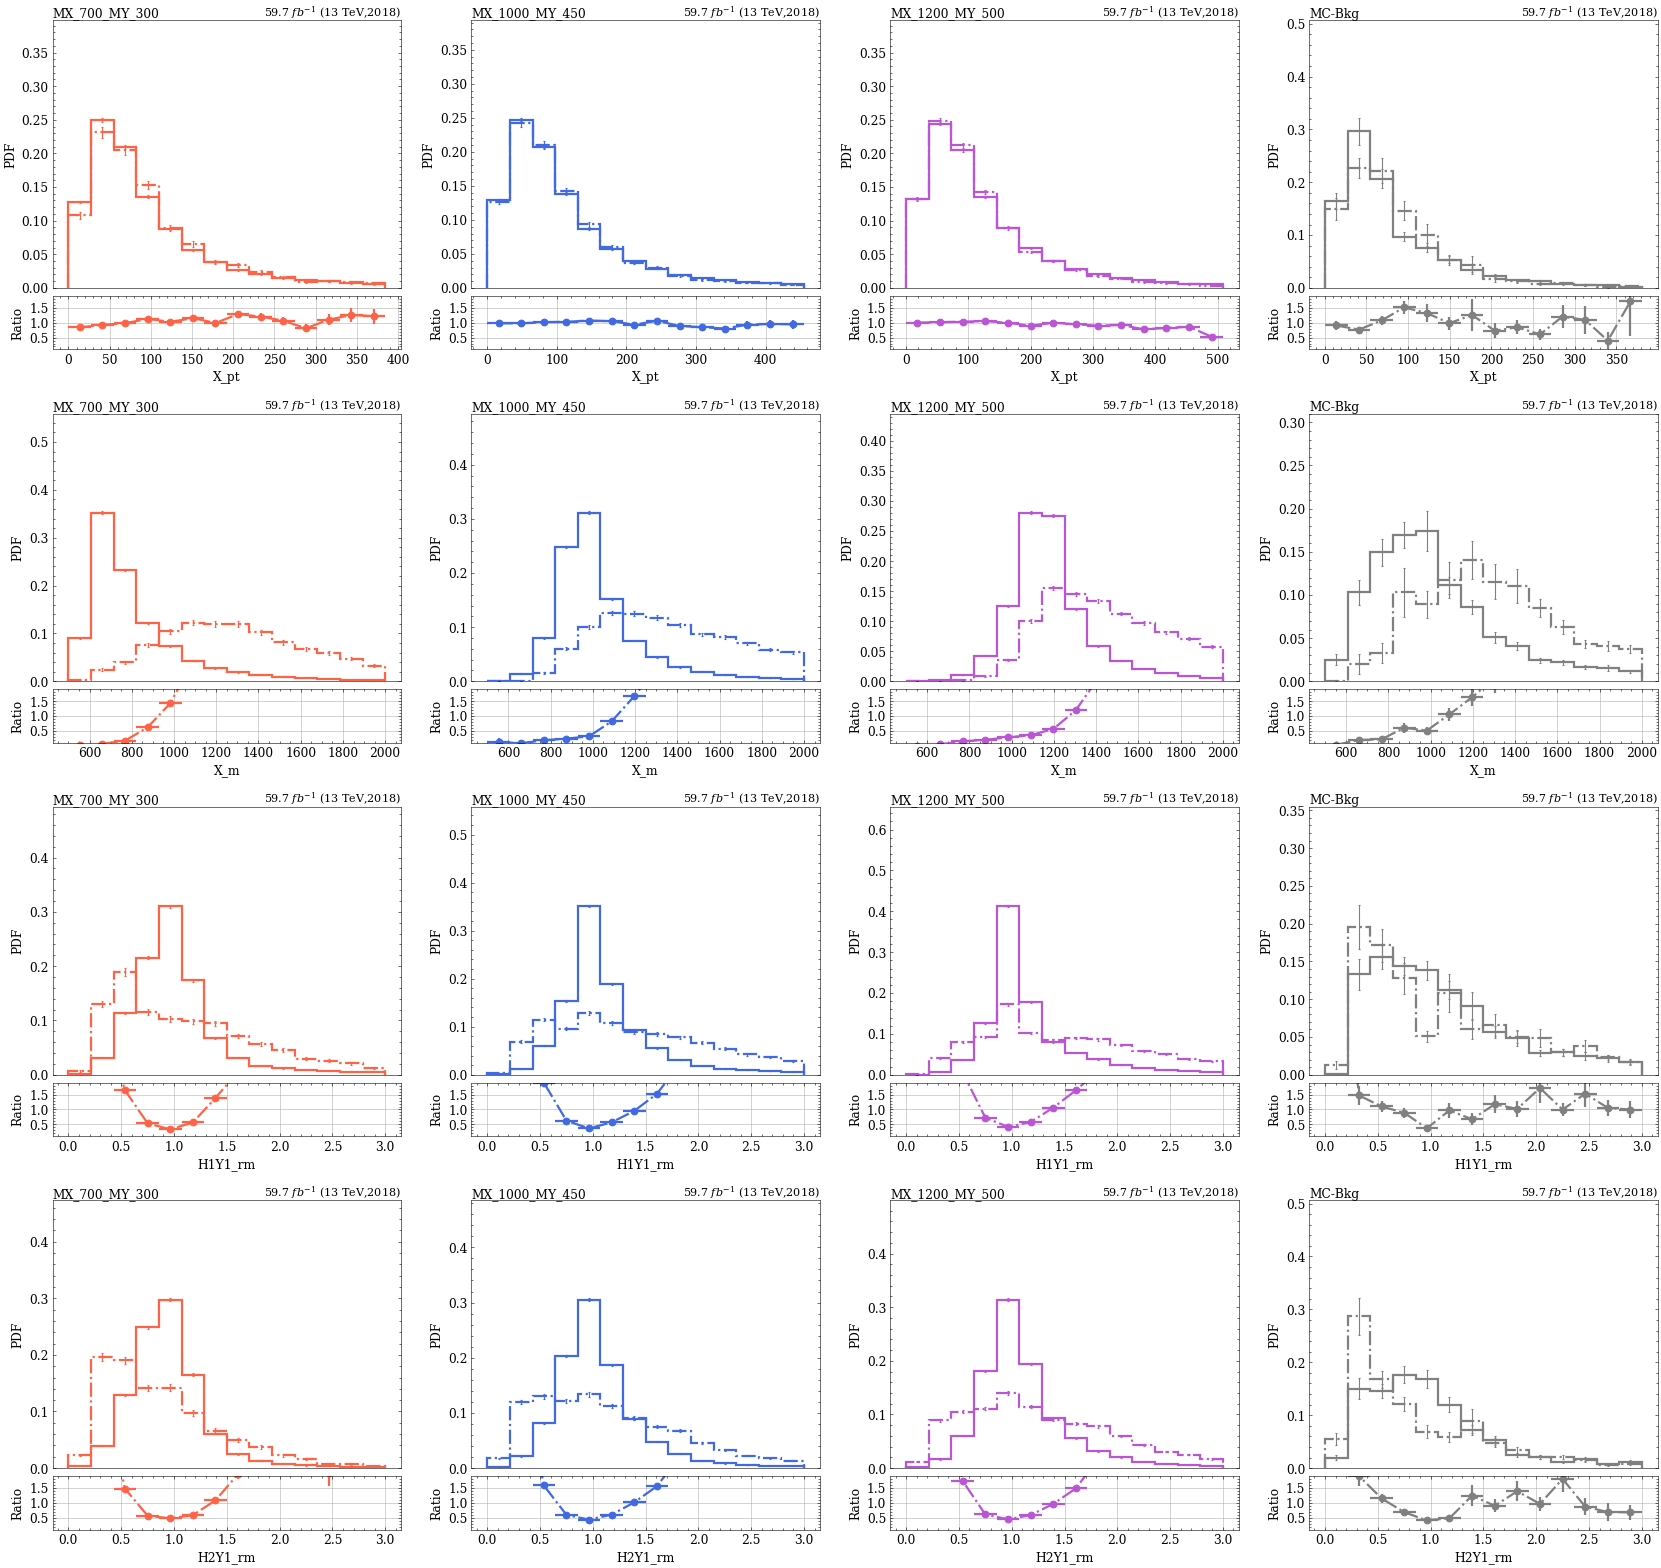

In [27]:
r = 1.0
study.compare_masks( 
    signal,bkg,
    efficiency=True,
    masks=[lambda t : np.sqrt( (t.H1Y2_rm-1)**2+(t.H2Y2_rm-1)**2 ) < r, lambda t : np.sqrt( (t.H1Y2_rm-1)**2+(t.H2Y2_rm-1)**2 ) > r ],
    varlist=['X_pt','X_m','H1Y1_rm','H2Y1_rm'],
    binlist=[None,(500,2000,30)]+[(0,3,30)]*2,
    h_rebin=15,
    ratio=True,r_inv=True
)

100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


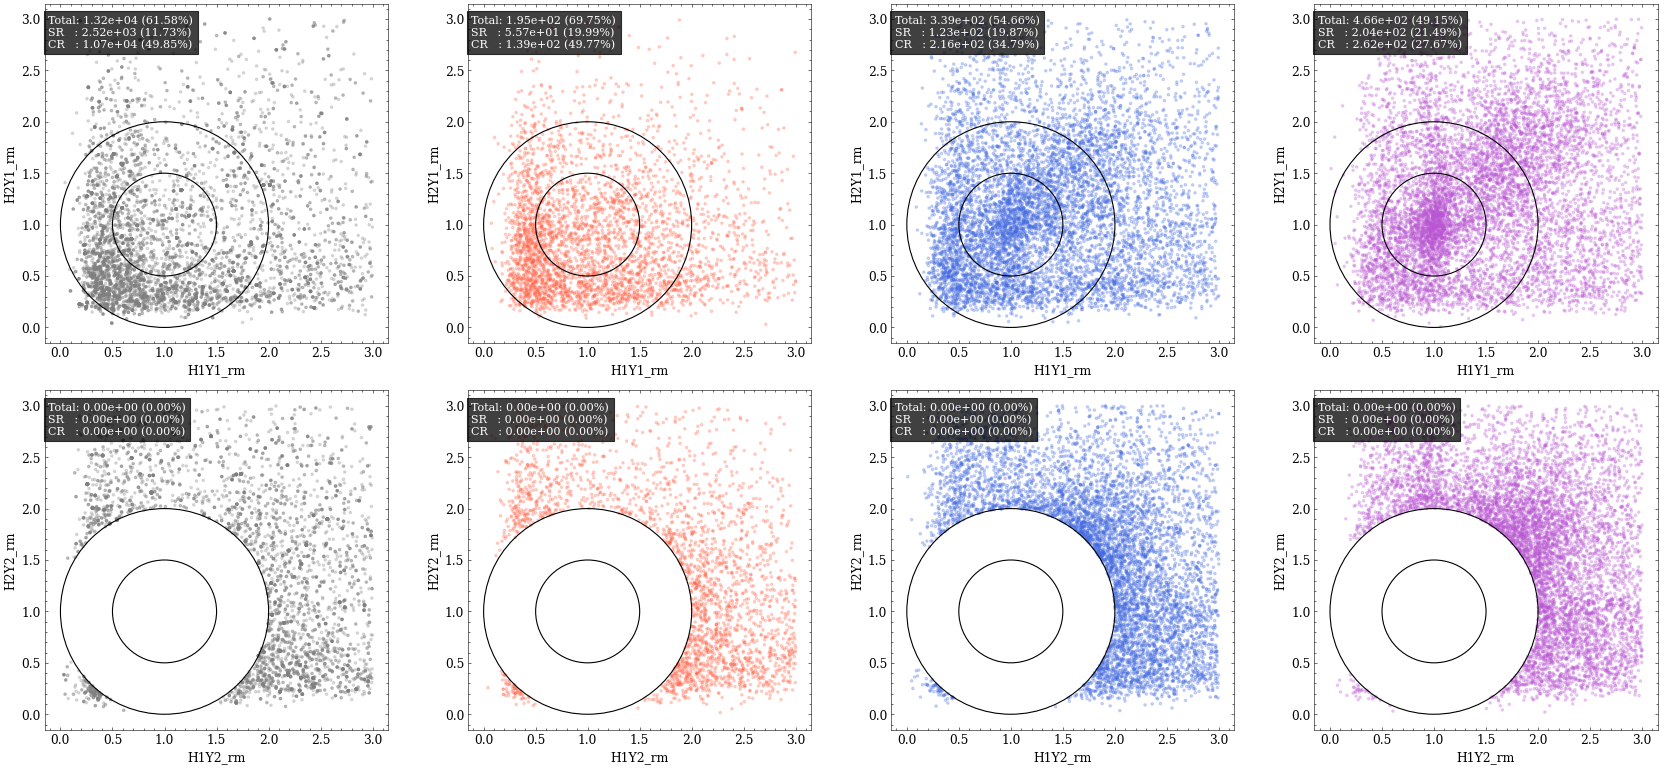

In [28]:
study.quick2d( 
    signal+bkg,
    masks=lambda t : np.sqrt( (t.H1Y2_rm-1)**2+(t.H2Y2_rm-1)**2 ) > r ,
    varlist=[f'{h}_rm' for h in eightb.higgslist],
    binlist=[(0,3,30)]*4,
    scatter=True,
    exe=draw_concentric(x=1,y=1,r1=0.5,r2=1.0)
)

In [29]:
ar_mask = lambda t : np.sqrt( (t.H1Y2_rm-1)**2+(t.H2Y2_rm-1)**2 ) < r
vr_mask = lambda t : np.sqrt( (t.H1Y2_rm-1)**2+(t.H2Y2_rm-1)**2 ) > r


100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


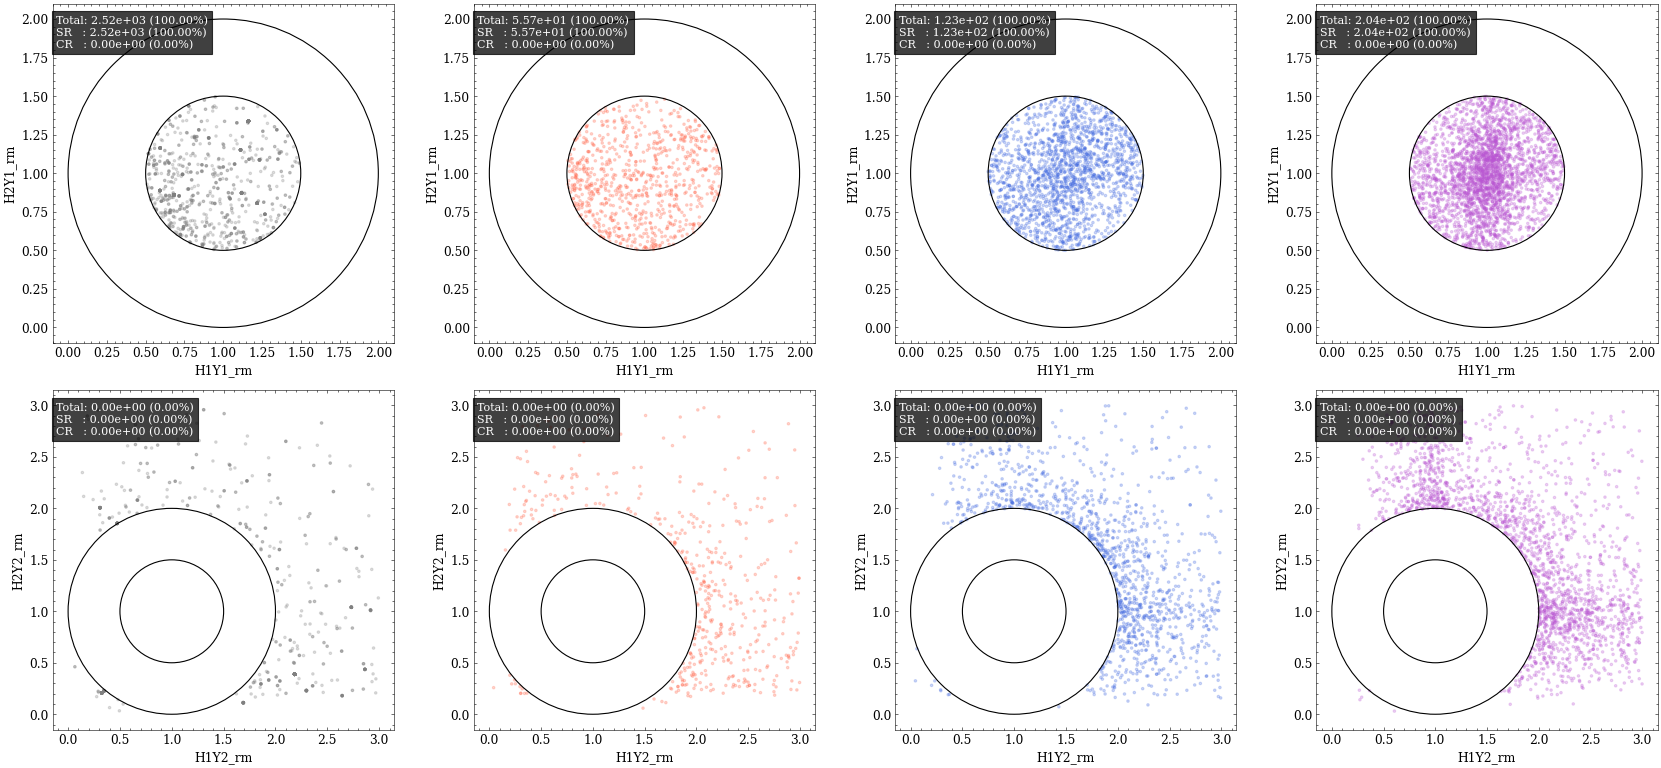

In [30]:
study.quick2d( 
    signal+bkg,
    masks=lambda t : vr_mask(t) & (np.sqrt( (t.H1Y1_rm-1)**2+(t.H2Y1_rm-1)**2 ) < 0.5) ,
    varlist=[f'{h}_rm' for h in eightb.higgslist],
    binlist=[(0,3,30)]*4,
    scatter=True,
    exe=draw_concentric(x=1,y=1,r1=0.5,r2=1.0)
)

100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


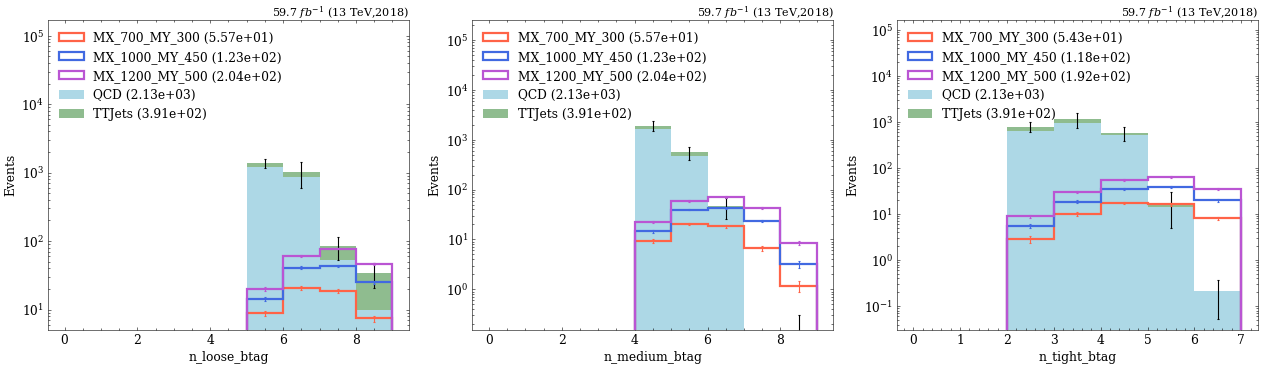

In [31]:
study.quick( 
    signal+bkg,
    legend=True,
    log=True,
    masks=lambda t : vr_mask(t) & (np.sqrt( (t.H1Y1_rm-1)**2+(t.H2Y1_rm-1)**2 ) < 0.5) ,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    dim=-1,
)

100%|██████████| 1/1 [00:15<00:00, 15.17s/it]


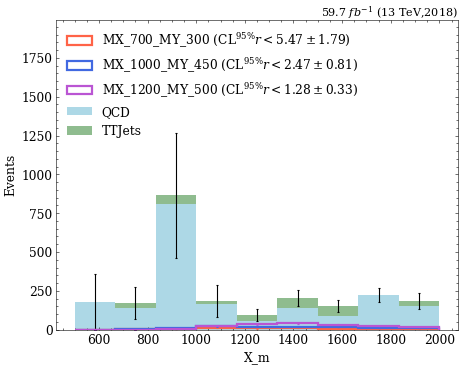

In [43]:
study.quick( 
    signal+bkg,
    legend=True, limits=True,
    masks=lambda t : vr_mask(t) & (np.sqrt( (t.H1Y1_rm-1)**2+(t.H2Y1_rm-1)**2 ) < 0.5) ,
    varlist=['X_m'],
    binlist=[(500,2000,10)],
)

100%|██████████| 1/1 [00:12<00:00, 12.14s/it]


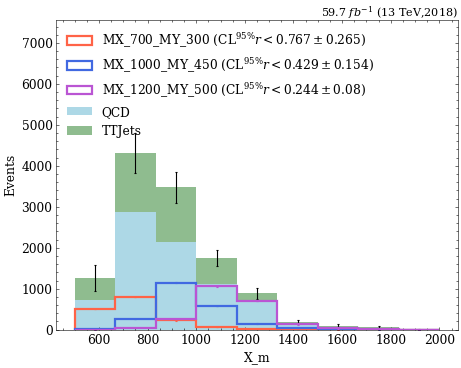

In [44]:
study.quick( 
    signal+bkg,
    legend=True, limits=True,
    masks=lambda t : ar_mask(t) & (np.sqrt( (t.H1Y1_rm-1)**2+(t.H2Y1_rm-1)**2 ) < 0.5) ,
    varlist=['X_m'],
    binlist=[(500,2000,10)],
)